# Principal Components Analysis - Assignment 5 

In [1]:
# References:
# https://www.kaggle.com/geochatz/mnist-digit-recognizer-classification-models
# https://www.kaggle.com/arthurtok/interactive-intro-to-dimensionality-reduction

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# import base packages into the namespace for this program
import numpy as np
import pandas as pd

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from math import sqrt  # for root mean-squared error calculation
import seaborn as sns  # pretty plotting, including heat map

In [2]:
# read data 
# creating data frame 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

## EDA

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.shape

(42000, 785)

In [5]:
X_train = train.drop(['label'], axis=1).values
y_train = train['label']

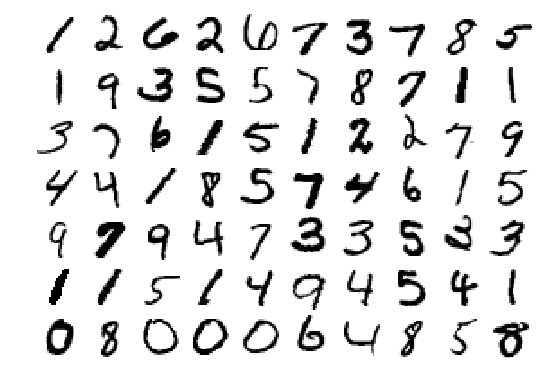

In [6]:
import matplotlib
import matplotlib.pyplot as plt
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
example_images = np.r_[X_train[:12000:600], X_train[13000:30600:600], X_train[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

Visually, not all numbers are the same, take the two fours at the start of the fourth row.  One is slanted to the left, the other is slanted to the right, and others throughout have differences as well.  

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

## Random Forest

First step is to run random grid search for the random forest.  Due to the size of the data set and time constraints, ten iterations with 3 fold cross validation was run.

In [9]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 231, 452, 673, 894, 1115, 1336, 1557, 1778, 2000]}


In [10]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(n_jobs=1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = 1)
# Fit the random search model
rf_random.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   1.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   1.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   1.1s
[CV] n_estimators=452, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=452, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, total= 1.0min
[CV] n_estimators=452, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=452, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, total= 1.0min
[CV] n_estimators=452, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=452, mi

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 50.8min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [10, 231, 452, 673, 894, 1115, 1336, 1557, 1778, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [11]:
rf_random.best_params_
#{'n_estimators': 2000,
# 'min_samples_split': 2,
# 'min_samples_leaf': 2,
# 'max_features': 'auto',
# 'max_depth': 50,
# 'bootstrap': False}

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

The restuls of the random grid search gave the previous best parameters to be used in a model.

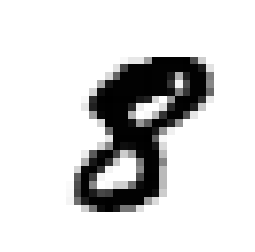

In [11]:
some_digit = X_train[10]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

Next step is to run cross validation using the best parameters from the radnomized grid search.  5 fold cross validation was run, a quick baseline model with 10 estimators was run at first then followed up by the best parameters.

In [12]:
from sklearn.model_selection import cross_val_score
forest_clf = RandomForestClassifier(random_state=42, n_estimators=2000, min_samples_split=2, 
                                    min_samples_leaf=2, max_features='auto', max_depth=50,
                                   bootstrap=False, n_jobs=-1)
forest_scores = cross_val_score(forest_clf, X_train_scaled, y_train, cv=5)
forest_scores.mean()
#0.9369749664144728, n_estimators=10
#0.0.9686669164811079, n_estimators=2000

0.9686669164811079

Using the best parameters found from randomized grid search resulted in a cross validated accuracy of 0.9687 whereas the baseline with only 10 estimators had an accuracy of 0.93697.  

In [13]:
from sklearn.model_selection import cross_val_predict
forest_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=5)

### Timed Random Forest

The next step is to run a random forest model using the best parameters on the entire training data set.

In [14]:
from datetime import datetime
forest_clf = RandomForestClassifier(random_state=42, n_estimators=2000, min_samples_split=2, 
                                    min_samples_leaf=2, max_features='auto', max_depth=50,
                                   bootstrap=False, n_jobs=-1)
start=datetime.now()
forest_clf.fit(X_train_scaled, y_train)
end=datetime.now()
print(end-start)

0:01:23.653194


The model took 1 minute and 23 seconds to run.  Given the size of the dataset and the number of estimators in the random forest this was done pretty quickly.  This is due to the model being done in parallel on a 12 core CPU.  Next step is to predict on the test set.

In [15]:
X_test=test.copy().values
X_test_scaled = scaler.transform(X_test.astype(np.float64))

In [16]:
y_pred = forest_clf.predict(X_test_scaled)
print(y_pred.shape)
y_pred

(28000,)


array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [17]:
test['Label'] = y_pred.ravel()
test['ImageId']= np.arange(1, len(test)+1)
test[['ImageId','Label']].head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


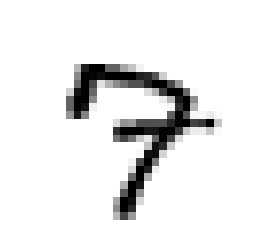

In [18]:
some_digit = X_test[5]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [19]:
test[['ImageId','Label']].to_csv('submission_rf.csv', index=False)

Checking the labels on the test set in comparision to some of the figures shows that the model should have pretty good results when submitted to kaggle.  The test set was then written to a submission file and scored 0.96957 on the public leaderboard.

In [20]:
forest_clf.predict_proba(X_test_scaled)

array([[1.50000000e-03, 7.50000000e-04, 9.87000000e-01, ...,
        1.66666667e-03, 1.66666667e-03, 5.83333333e-04],
       [9.79416667e-01, 0.00000000e+00, 4.25000000e-03, ...,
        2.41666667e-03, 2.16666667e-03, 1.50000000e-03],
       [2.41666667e-03, 8.25000000e-03, 9.08333333e-03, ...,
        5.42500000e-02, 5.66666667e-02, 6.93233333e-01],
       ...,
       [0.00000000e+00, 2.50000000e-04, 0.00000000e+00, ...,
        0.00000000e+00, 5.83333333e-04, 0.00000000e+00],
       [2.83333333e-03, 7.50000000e-04, 1.58333333e-03, ...,
        8.91666667e-03, 7.83333333e-03, 8.93833333e-01],
       [1.25833333e-02, 6.66666667e-04, 8.97416667e-01, ...,
        4.33333333e-03, 2.22500000e-02, 1.44166667e-02]])

## PCA

Next I want to look at the effects of running PCA on the data set and how that impacts the time to train as well as the accuracy of the model.  

In [21]:
from sklearn.decomposition import PCA
# Call the PCA method with 5 components. 
start=datetime.now()
pca = PCA(n_components=.95)
pca.fit(X_train_scaled)
end=datetime.now()
print(end-start)
X_Train_PCA = pca.transform(X_train_scaled)
X_Test_PCA = pca.transform(X_test_scaled)

0:00:01.922766


Principal components that explain 95% of the variance was run in 1.92 seconds.

In [22]:
X_Train_PCA = pd.DataFrame(data=X_Train_PCA)

In [23]:
X_Test_PCA = pd.DataFrame(data=X_Test_PCA)

In [24]:
X_Train_PCA.head()

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
0,-5.140478,-5.226445,3.887001,-0.901512,4.929111,2.035413,4.706946,-4.767184,0.230958,-1.460962,...,0.366951,0.107895,0.642772,-0.193537,0.118451,-0.160279,0.115080,0.252282,-0.300996,-0.078579
1,19.292332,6.032996,1.308148,-2.383294,3.095188,-1.791095,-3.772790,0.153865,-4.115192,-4.299357,...,-0.173737,0.142810,0.388908,-0.150574,0.108410,-0.502759,0.188998,-0.156875,-0.261989,0.220046
2,-7.644503,-1.705813,2.289326,2.241135,5.094426,-4.152058,-1.012004,1.732559,0.436261,-0.073687,...,-0.264633,0.094898,-0.138479,-0.069568,0.173102,-0.041937,0.048120,0.223752,-0.049411,-0.223253
3,-0.474207,5.836139,2.008617,4.271106,2.377777,2.179913,4.398030,-0.353712,0.992308,5.501253,...,-0.417524,-0.207763,-0.764952,-0.045634,-0.200469,-1.400780,-2.416583,-0.266368,-0.681866,-0.658081
4,26.559574,6.024818,0.933179,-3.012645,9.489179,-2.331195,-6.149597,-1.783637,-4.123302,-5.757361,...,-0.768092,-0.916129,-0.745948,0.163309,0.244741,-0.311503,-0.694088,-0.178591,0.333128,0.485622


There were 320 components found that were used to explain 95% of the variance in the data set.  Next a random forest with the same parameters as earlier will be trained on the principal components. 

In [25]:
forest_clf = RandomForestClassifier(random_state=42, n_estimators=2000, min_samples_split=2, 
                                    min_samples_leaf=2, max_features='auto', max_depth=50,
                                   bootstrap=False, n_jobs=-1)
start=datetime.now()
forest_clf.fit(X_Train_PCA, y_train)
end=datetime.now()
print(end-start)

0:04:38.564836


The random forest took 4 minutes and 38 seconds this time around to train.  Interestingly, this is much longer than the model trained on the larger data set.  Ideally, another grid search would need to be done and the parameters adjusted for this specific data set.  If this model is used on the test set then it scores 0.94214 on the public leaderboard on Kaggle.  

In [29]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(n_jobs=1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = 1)
# Fit the random search model
rf_random.fit(X_Train_PCA, y_train)

rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   3.5s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   3.5s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   3.4s
[CV] n_estimators=452, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=452, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, total= 4.2min
[CV] n_estimators=452, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=452, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, total= 4.2min
[CV] n_estimators=452, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=452, mi

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 195.2min finished


{'n_estimators': 452,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': False}

In [30]:
forest_clf = RandomForestClassifier(random_state=42, n_estimators=452, min_samples_split=2, 
                                    min_samples_leaf=2, max_features='auto', max_depth=60,
                                   bootstrap=False, n_jobs=-1)
forest_scores = cross_val_score(forest_clf, X_Train_PCA, y_train, cv=5)
forest_scores.mean()
#0.9369749664144728, n_estimators=10
#0.0.9686669164811079, n_estimators=2000

0.9378335211458368

The cross validated score for the PCA model is much lower than the cross validated score for the entire data set.

In [31]:
forest_clf = RandomForestClassifier(random_state=42, n_estimators=452, min_samples_split=2, 
                                    min_samples_leaf=2, max_features='auto', max_depth=60,
                                   bootstrap=False, n_jobs=-1)
start=datetime.now()
forest_clf.fit(X_Train_PCA, y_train)
end=datetime.now()
print(end-start)

0:01:03.707074


In [32]:
y_pred = forest_clf.predict(X_Test_PCA)
print(y_pred.shape)
y_pred

(28000,)


array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [33]:
test['Label'] = y_pred.ravel()
test['ImageId']= np.arange(1, len(test)+1)
test[['ImageId','Label']].head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [34]:
test[['ImageId','Label']].to_csv('submission_rf_pca.csv', index=False)

## Conclusion

After running a random forest using randomized grid search on the entire data set a cross validated score of 0.9687 was obtained.  A single model trained on the entire data set took one minute and twenty-three seconds.  PCA was then done on the MNIST data set such that 95% of the variance was explained.  This resulted in 320 principal components.  Randomized grid search was then done on the PCA data set and cross validation was performed using the optimal parameters.  A cross validated score of 0.9378 was obtained.  A single model trained on the PCA data set took one minute and three seconds to run.  Overall, I believe that the small time benefit of training on PCA data is not worth the loss in accuracy of the final model.